In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import colorsys
import os

# --- Function to generate visually distinct colors ---
def generate_distinct_colors(n, bright=True):
    if n == 0:
        return []
    brightness = 1.0 if bright else 0.7
    colors = [colorsys.hsv_to_rgb(i / n, 0.7, brightness) for i in range(n)]
    return colors

# --- Function to slightly darken color for text labels ---
def darker_color(color, factor=0.6):
    rgba = to_rgba(color)
    return (rgba[0]*(1-factor), rgba[1]*(1-factor), rgba[2]*(1-factor), rgba[3])

# --- Set global style ---
plt.rcParams.update({
    'font.size': 16,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})


In [4]:
imports_all_countries = pd.read_csv(r'C:\Users\Investigador\binu\new_data\IndiaImportsAllCountries.csv')
imports_all_countries['TradeValue in 1000 USD'] = imports_all_countries['TradeValue in 1000 USD']/1000000

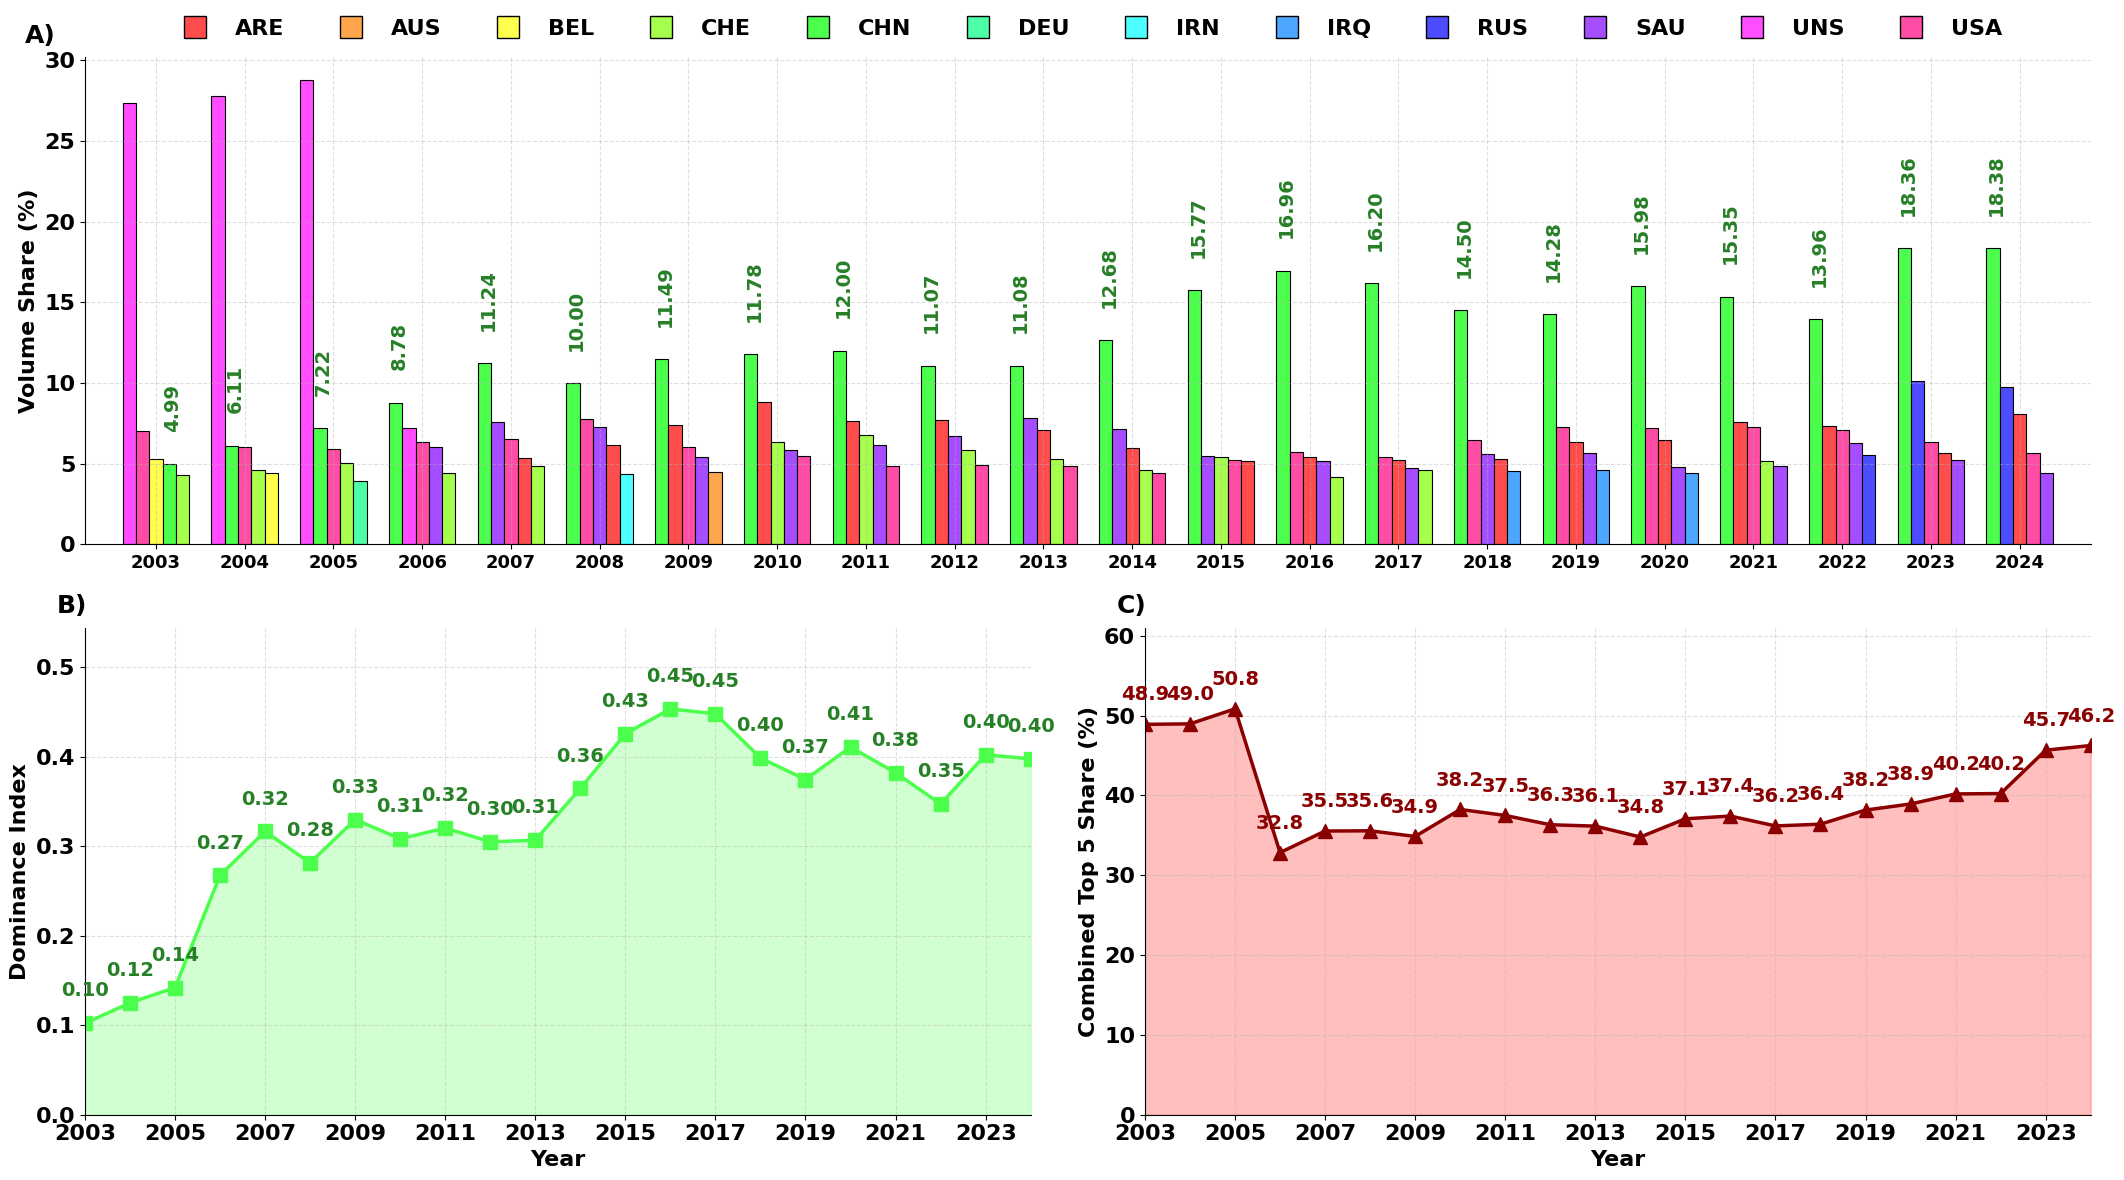

In [5]:
# --- Prepare DataFrame ---
df = imports_all_countries.copy()
df = df[df["TradeFlowCode"] == 5]

# --- Aggregate totals ---
total_world_per_year = df.groupby("Year")["TradeValue in 1000 USD"].sum()

# --- Top 5 partners per year ---
top5 = (
    df.groupby(["Year", "PartnerISO3"])["TradeValue in 1000 USD"]
    .sum()
    .groupby(level=0, group_keys=False)
    .nlargest(5)
    .reset_index()
)

top5_pivot = top5.pivot(index="Year", columns="PartnerISO3", values="TradeValue in 1000 USD").fillna(0)

# --- China share and combined top5 share ---
china_col = "CHN" if "CHN" in top5_pivot.columns else None
china_share = (top5_pivot[china_col] / top5_pivot.sum(axis=1) if china_col else pd.Series(0, index=top5_pivot.index))
combined_share = top5_pivot.sum(axis=1) / total_world_per_year[top5_pivot.index] * 100

# --- Prepare plotting DataFrame ---
top5_vol_per_year = pd.DataFrame({
    "Year": top5_pivot.index,
    "ChinaDI": china_share,
    "CombinedShare": combined_share
})

# --- Visualization setup ---
years = sorted(top5["Year"].unique())
unique_countries = sorted(top5["PartnerISO3"].unique())
palette = generate_distinct_colors(len(unique_countries))
colors = {c: palette[i] for i, c in enumerate(unique_countries)}

bar_width = 0.15
fig = plt.figure(figsize=(22, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# --- Panel A: Top 5 import shares ---
total_china_per_year = top5_pivot[china_col] if china_col else pd.Series(0, index=top5_pivot.index)
for idx, year in enumerate(years):
    year_data = top5[top5["Year"] == year]
    if year_data.empty:
        continue
    n_countries_year = len(year_data)
    offsets = np.linspace(-(n_countries_year - 1) / 2, (n_countries_year - 1) / 2, n_countries_year) * bar_width
    for i, (_, row) in enumerate(year_data.iterrows()):
        share_value = row["TradeValue in 1000 USD"] / total_world_per_year.get(year, 1) * 100
        color = colors.get(row["PartnerISO3"], "gray")
        ax1.bar(idx + offsets[i], share_value, width=bar_width, color=color, edgecolor='black', linewidth=0.8)
        if row["PartnerISO3"] == "CHN":
            ax1.text(idx + offsets[i]+0.04, share_value + 2, f'{share_value:.2f}',
                     ha='center', va='bottom', fontsize=14, fontweight='bold',
                     color=darker_color(color, factor=0.5), rotation=90)

ax1.set_ylabel('Volume Share (%)', fontsize=16, fontweight='bold')
ax1.set_xticks(np.arange(len(years)))
ax1.set_xticklabels(years, fontsize=13, fontweight='bold')
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlim(-0.5 - bar_width*2, len(years) - 0.5 + bar_width*2)
ax1.text(-0.03, 1.03, 'A)', transform=ax1.transAxes, fontsize=18, fontweight='bold')

# --- Panel B: China Dominance Index ---
ax2.plot(top5_vol_per_year["Year"], top5_vol_per_year["ChinaDI"], marker='s', markersize=10,
         color=colors.get('CHN', 'gray'), linewidth=2.5)
ax2.fill_between(top5_vol_per_year["Year"], top5_vol_per_year["ChinaDI"],
                 color=colors.get('CHN', 'gray'), alpha=0.25)
for i, val in enumerate(top5_vol_per_year["ChinaDI"]):
    ax2.text(top5_vol_per_year["Year"].iloc[i], val + 0.03, f'{val:.2f}',
             ha='center', fontsize=14, fontweight='bold', color=darker_color(colors.get('CHN', 'gray'), 0.5))

ax2.set_xlabel('Year', fontsize=16, fontweight='bold')
ax2.set_ylabel('Dominance Index', fontsize=16, fontweight='bold')
ax2.spines[['top', 'right']].set_visible(False)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.set_ylim(0, max(top5_vol_per_year["ChinaDI"]) * 1.2 if top5_vol_per_year["ChinaDI"].max() > 0 else 1)
ax2.set_xlim(min(years), max(years))
ax2.text(-0.03, 1.03, 'B)', transform=ax2.transAxes, fontsize=18, fontweight='bold')

# --- Panel C: Combined Top 5 Share ---
ax3.plot(top5_vol_per_year["Year"], top5_vol_per_year["CombinedShare"], marker='^', markersize=10,
         color='darkred', linewidth=2.5)
ax3.fill_between(top5_vol_per_year["Year"], top5_vol_per_year["CombinedShare"], color='red', alpha=0.25)
for i, val in enumerate(top5_vol_per_year["CombinedShare"]):
    ax3.text(top5_vol_per_year["Year"].iloc[i], val + 3, f'{val:.1f}',
             ha='center', fontsize=14, fontweight='bold', color='darkred')

ax3.set_xlabel('Year', fontsize=16, fontweight='bold')
ax3.set_ylabel('Combined Top 5 Share (%)', fontsize=16, fontweight='bold')
ax3.spines[['top', 'right']].set_visible(False)
ax3.grid(True, linestyle='--', alpha=0.4)
ax3.set_ylim(0, max(top5_vol_per_year["CombinedShare"]) * 1.2)
ax3.set_xlim(min(years), max(years))
ax3.text(-0.03, 1.03, 'C)', transform=ax3.transAxes, fontsize=18, fontweight='bold')

# --- Legend ---
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[c], markeredgecolor='black', markersize=16) for c in unique_countries]
ax1.legend(handles, unique_countries, fontsize=16, loc='upper center',
           bbox_to_anchor=(0.5, 1.12), ncol=len(colors), frameon=False)

# --- X-ticks for Panels B & C ---
step = max(1, len(years) // 8)
display_years = years[::step]
ax2.set_xticks(display_years)
ax2.set_xticklabels(display_years)
ax3.set_xticks(display_years)
ax3.set_xticklabels(display_years)

# --- Save figure ---
os.makedirs('images', exist_ok=True)
plt.tight_layout()
plt.savefig('images/Figure_2_ABC.png', dpi=800)
plt.show()
